# HyperbolicTSNE

This notebook illustrates the usage of the HyperbolicTSNE library. Specifically, we load a subset of the MNIST dataset and embed it in hyperbolic space using the accelerated version of hyperbolic tsne. Finally, we save the embedding result as an image.

## Setup

First, we import the packages we will use and set important paths. Note that `hyperbolicTSNE.util` and `hyperbolicTSNE.visualization` contain useful functions for reading, processing and exporting embeddings. This requires that hyperbolicTSNE has been set up as detailed in the main readme of the repository. 

In [1]:
import os
import traceback

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


We assume that there is a top-level folder `datasets` that holds the MNIST data set. Refer to the main readme of the repository for where to find the data sets used in this repository.

In [2]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots

## Configure

HyperbolicTSNE follows a similar API to other t-SNE libraries like OpenTSNE and sklearn. The configuration process consists of loading the data to embed and defining the settings of the embedder. We create a dict with parameters manually to demonstrate all the customization options. Nevertheless, `hyperbolicTSNE.hyperbolicTSNE` provides parameter templates to start with.

In [3]:
only_animate = False
seed = 42
dataset = Datasets.C_ELEGANS  # the Datasets handler provides access to several data sets used throughout the repository
num_points = 10000  # we use a subset for demonstration purposes, full MNIST has N=70000
perp = 30  # we use a perplexity of 30 in this example

dataX, dataLabels, D, V, _ = load_data(
    dataset, 
    data_home=data_home, 
    random_state=seed, 
    to_return="X_labels_D_V",
    hd_params={"perplexity": perp}, 
    sample=num_points, 
    knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
)

In [4]:
exaggeration_factor = 12  # Just like regular t-SNE, we use early exaggeration with a factor of 12
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)  # We adjust the learning rate to the hyperbolic setting
ex_iterations = 250  # The embedder is to execute 250 iterations of early exaggeration, ...
main_iterations = 750  # ... followed by 750 iterations of non-exaggerated gradient descent.

opt_config = dict(
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exaggeration_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
    momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
    momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
    exact=False,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
    area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
    n_iter_check=10,  # Needed for early stopping criterion
    size_tol=0.999  # Size of the embedding to be used as early stopping criterion
)

opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

# Start: configure logging
logging_dict = {
    "log_path": log_path
}
opt_params["logging_dict"] = logging_dict

log_path = opt_params["logging_dict"]["log_path"]
# Delete old log path
if os.path.exists(log_path) and not only_animate:
    import shutil
    shutil.rmtree(log_path)
# End: logging

print(f"config: {opt_config}")

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'learning_rate_ex': 0.8333333333333334, 'learning_rate_main': 0.8333333333333334, 'exaggeration': 12, 'exaggeration_its': 250, 'gradientDescent_its': 750, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': False, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999}


## Run HyperbolicTSNE

Embedding the high dimensional data consists of three steps:
- Initializating the embedding
- Initializing the embedder 
- Embedding the data

The following three cells demonstrate this process. Note that use set metric to "precomputed" because we pass the distance matrix to the `fit` method.

In [5]:
# Compute an initial embedding of the data via PCA
X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)

In [6]:
# Initialize the embedder
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer, 
    opt_params=opt_params
)

In [7]:
# Compute the embedding
try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
except ValueError:
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: True
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 58.06725 grad_norm: 6.51675e-01:   2%|██▏                                                                                         | 6/250 [00:00<00:17, 14.34it/s]

[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 cloc

Gradient Descent error: 58.06839 grad_norm: 6.56747e-01:   5%|████▎                                                                                      | 12/250 [00:00<00:17, 13.52it/s]

NE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock

Gradient Descent error: 58.06899 grad_norm: 6.64118e-01:   7%|██████▌                                                                                    | 18/250 [00:01<00:18, 12.48it/s]

-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock 

Gradient Descent error: 58.06753 grad_norm: 6.70415e-01:   9%|████████                                                                                   | 22/250 [00:01<00:19, 11.49it/s]

computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | F

Gradient Descent error: 58.06719 grad_norm: 6.87310e-01:  12%|██████████▉                                                                                | 30/250 [00:02<00:14, 14.67it/s]

NE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ti

Gradient Descent error: 58.06832 grad_norm: 6.78080e-01:  14%|████████████▍                                                                              | 34/250 [00:02<00:16, 12.75it/s]

E] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock tic

Gradient Descent error: 58.06798 grad_norm: 6.81372e-01:  16%|██████████████▌                                                                            | 40/250 [00:02<00:14, 14.78it/s]

] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | F

Gradient Descent error: 58.06741 grad_norm: 6.83462e-01:  18%|████████████████▋                                                                          | 46/250 [00:03<00:13, 14.69it/s]

 Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks

Gradient Descent error: 58.06719 grad_norm: 6.85596e-01:  20%|██████████████████▏                                                                        | 50/250 [00:03<00:13, 15.29it/s]

Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks


Gradient Descent error: 58.06227 grad_norm: 6.94793e-01:  22%|████████████████████▍                                                                      | 56/250 [00:03<00:11, 16.49it/s]

ree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[

Gradient Descent error: 58.06742 grad_norm: 6.88599e-01:  25%|██████████████████████▌                                                                    | 62/250 [00:04<00:12, 15.34it/s]

ee: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t

Gradient Descent error: 58.06718 grad_norm: 6.90063e-01:  27%|████████████████████████▊                                                                  | 68/250 [00:04<00:13, 13.78it/s]

e: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-

Gradient Descent error: 58.06235 grad_norm: 6.97640e-01:  29%|██████████████████████████▏                                                                | 72/250 [00:05<00:11, 14.84it/s]

: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-S

Gradient Descent error: 58.06816 grad_norm: 6.92363e-01:  31%|████████████████████████████▍                                                              | 78/250 [00:05<00:12, 13.99it/s]

 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SN

Gradient Descent error: 58.06854 grad_norm: 6.93342e-01:  34%|██████████████████████████████▌                                                            | 84/250 [00:05<00:10, 15.21it/s]

0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE

Gradient Descent error: 58.06552 grad_norm: 6.99716e-01:  35%|████████████████████████████████                                                           | 88/250 [00:06<00:11, 14.01it/s]

ock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE]

Gradient Descent error: 58.06625 grad_norm: 7.00337e-01:  38%|██████████████████████████████████▏                                                        | 94/250 [00:06<00:10, 15.27it/s]

clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] 

Gradient Descent error: 58.06718 grad_norm: 6.95735e-01:  39%|███████████████████████████████████▋                                                       | 98/250 [00:07<00:11, 13.41it/s]

lock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] T

Gradient Descent error: 58.06718 grad_norm: 6.96538e-01:  42%|█████████████████████████████████████▍                                                    | 104/250 [00:07<00:11, 12.31it/s]

ock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tr

Gradient Descent error: 58.06807 grad_norm: 6.97223e-01:  44%|███████████████████████████████████████▌                                                  | 110/250 [00:07<00:11, 12.51it/s]

ck ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tre

Gradient Descent error: 58.06721 grad_norm: 6.97681e-01:  46%|█████████████████████████████████████████                                                 | 114/250 [00:08<00:11, 11.45it/s]

k ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree

Gradient Descent error: 58.06779 grad_norm: 6.98301e-01:  48%|███████████████████████████████████████████▏                                              | 120/250 [00:08<00:10, 12.74it/s]

ck ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree:

Gradient Descent error: 58.06764 grad_norm: 6.98546e-01:  50%|█████████████████████████████████████████████▎                                            | 126/250 [00:09<00:11, 10.58it/s]

ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 

Gradient Descent error: 58.06433 grad_norm: 7.03130e-01:  53%|███████████████████████████████████████████████▌                                          | 132/250 [00:09<00:09, 12.06it/s]

 ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0

Gradient Descent error: 58.06836 grad_norm: 6.99298e-01:  54%|████████████████████████████████████████████████▉                                         | 136/250 [00:10<00:08, 12.85it/s]

cks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clo

Gradient Descent error: 58.06810 grad_norm: 7.03494e-01:  57%|███████████████████████████████████████████████████                                       | 142/250 [00:10<00:08, 12.21it/s]

ks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 c

Gradient Descent error: 58.06437 grad_norm: 7.03862e-01:  59%|█████████████████████████████████████████████████████▎                                    | 148/250 [00:11<00:07, 13.95it/s]

s | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 cl

Gradient Descent error: 58.06830 grad_norm: 7.00884e-01:  61%|██████████████████████████████████████████████████████▋                                   | 152/250 [00:11<00:07, 13.30it/s]

 | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clo

Gradient Descent error: 58.06729 grad_norm: 7.01368e-01:  63%|████████████████████████████████████████████████████████▉                                 | 158/250 [00:11<00:06, 13.20it/s]

| Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 cloc

Gradient Descent error: 58.06435 grad_norm: 7.04736e-01:  66%|███████████████████████████████████████████████████████████                               | 164/250 [00:12<00:06, 13.04it/s]

 Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock

Gradient Descent error: 58.06826 grad_norm: 7.01955e-01:  68%|█████████████████████████████████████████████████████████████▏                            | 170/250 [00:12<00:05, 13.96it/s]

[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock 

Gradient Descent error: 58.06722 grad_norm: 7.02166e-01:  70%|██████████████████████████████████████████████████████████████▋                           | 174/250 [00:13<00:05, 13.90it/s]

orce computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock

Gradient Descent error: 58.06435 grad_norm: 7.05446e-01:  72%|████████████████████████████████████████████████████████████████▊                         | 180/250 [00:13<00:05, 12.35it/s]

-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock 

Gradient Descent error: 58.06812 grad_norm: 7.05775e-01:  74%|██████████████████████████████████████████████████████████████████▉                       | 186/250 [00:13<00:05, 12.43it/s]

ce computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock tic

Gradient Descent error: 58.06724 grad_norm: 7.02979e-01:  77%|█████████████████████████████████████████████████████████████████████                     | 192/250 [00:14<00:04, 14.08it/s]

e computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock tick

Gradient Descent error: 58.06447 grad_norm: 7.06066e-01:  78%|██████████████████████████████████████████████████████████████████████▌                   | 196/250 [00:14<00:04, 13.38it/s]

 computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks

Gradient Descent error: 58.06645 grad_norm: 7.06410e-01:  81%|████████████████████████████████████████████████████████████████████████▋                 | 202/250 [00:15<00:03, 12.54it/s]

computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks 

Gradient Descent error: 58.06726 grad_norm: 7.03663e-01:  83%|██████████████████████████████████████████████████████████████████████████▉               | 208/250 [00:15<00:03, 13.34it/s]

omputation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks

Gradient Descent error: 58.06763 grad_norm: 7.03986e-01:  85%|████████████████████████████████████████████████████████████████████████████▎             | 212/250 [00:16<00:02, 12.96it/s]

mputation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks


Gradient Descent error: 58.06764 grad_norm: 7.04250e-01:  87%|██████████████████████████████████████████████████████████████████████████████▍           | 218/250 [00:16<00:02, 12.37it/s]

: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[

Gradient Descent error: 58.06439 grad_norm: 7.07374e-01:  90%|████████████████████████████████████████████████████████████████████████████████▋         | 224/250 [00:16<00:02, 12.75it/s]

utation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t

Gradient Descent error: 58.06838 grad_norm: 7.05027e-01:  92%|██████████████████████████████████████████████████████████████████████████████████▊       | 230/250 [00:17<00:01, 13.82it/s]

tation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | For

Gradient Descent error: 58.06643 grad_norm: 7.07792e-01:  94%|████████████████████████████████████████████████████████████████████████████████████▏     | 234/250 [00:17<00:01, 13.84it/s]

: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Forc

Gradient Descent error: 58.06431 grad_norm: 7.07858e-01:  96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 240/250 [00:18<00:00, 12.08it/s]

tion: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force

Gradient Descent error: 58.06764 grad_norm: 7.05472e-01:  98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 244/250 [00:18<00:00, 13.02it/s]

ion: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force com

Gradient Descent error: 58.06762 grad_norm: 7.05389e-01: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:18<00:00, 13.26it/s]


on: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force c

Gradient Descent error: 2.35431 grad_norm: 5.88819e-02:   1%|▋                                                                                            | 6/750 [00:00<00:56, 13.17it/s]

n: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force co

Gradient Descent error: 2.35433 grad_norm: 5.56018e-02:   2%|█▍                                                                                          | 12/750 [00:00<00:52, 13.93it/s]

lock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force com

Gradient Descent error: 2.35432 grad_norm: 5.66775e-02:   2%|██▏                                                                                         | 18/750 [00:01<00:53, 13.81it/s]

ock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force comp

Gradient Descent error: 2.35431 grad_norm: 5.69633e-02:   3%|██▋                                                                                         | 22/750 [00:01<00:50, 14.36it/s]

0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force compu

Gradient Descent error: 2.35433 grad_norm: 5.70809e-02:   4%|███▍                                                                                        | 28/750 [00:02<00:52, 13.88it/s]

 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force comput

Gradient Descent error: 2.35434 grad_norm: 5.71479e-02:   4%|███▉                                                                                        | 32/750 [00:02<00:54, 13.14it/s]

 ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree:

Gradient Descent error: 2.35432 grad_norm: 5.74424e-02:   5%|████▉                                                                                       | 40/750 [00:02<00:49, 14.40it/s]

ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computat

Gradient Descent error: 2.35432 grad_norm: 5.75553e-02:   6%|█████▍                                                                                      | 44/750 [00:03<00:55, 12.81it/s]

ock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computati

Gradient Descent error: 2.35433 grad_norm: 5.76300e-02:   7%|██████▏                                                                                     | 50/750 [00:03<00:54, 12.89it/s]

ck ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 

Gradient Descent error: 2.35432 grad_norm: 5.76932e-02:   7%|██████▊                                                                                     | 56/750 [00:04<00:48, 14.21it/s]

k ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation

Gradient Descent error: 2.35433 grad_norm: 5.77010e-02:   8%|███████▎                                                                                    | 60/750 [00:04<00:50, 13.60it/s]

 ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation:

Gradient Descent error: 2.35434 grad_norm: 5.77395e-02:   9%|████████                                                                                    | 66/750 [00:04<00:47, 14.50it/s]

ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 

Gradient Descent error: 2.35432 grad_norm: 5.78490e-02:  10%|████████▊                                                                                   | 72/750 [00:05<00:46, 14.59it/s]

icks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 cloc

Gradient Descent error: 2.35433 grad_norm: 5.79184e-02:  10%|█████████▌                                                                                  | 78/750 [00:05<00:44, 15.00it/s]

cks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 

Gradient Descent error: 2.35434 grad_norm: 5.78129e-02:  11%|██████████                                                                                  | 82/750 [00:05<00:47, 14.00it/s]

Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 c

Gradient Descent error: 2.35434 grad_norm: 5.78237e-02:  11%|██████████▌                                                                                 | 86/750 [00:06<00:46, 14.35it/s]

s
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 cl

Gradient Descent error: 2.35433 grad_norm: 5.76545e-02:  13%|███████████▌                                                                                | 94/750 [00:06<00:43, 14.91it/s]


[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock 

Gradient Descent error: 2.35434 grad_norm: 5.77608e-02:  13%|████████████                                                                                | 98/750 [00:07<00:44, 14.52it/s]

[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 cloc

Gradient Descent error: 2.35431 grad_norm: 5.77724e-02:  14%|████████████▌                                                                              | 104/750 [00:07<00:53, 12.09it/s]

utation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock

Gradient Descent error: 2.35433 grad_norm: 5.77159e-02:  15%|█████████████▎                                                                             | 110/750 [00:08<00:51, 12.41it/s]

-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | 

Gradient Descent error: 2.35432 grad_norm: 5.77632e-02:  15%|█████████████▊                                                                             | 114/750 [00:08<00:49, 12.82it/s]

SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock t

Gradient Descent error: 2.35433 grad_norm: 5.76954e-02:  16%|██████████████▌                                                                            | 120/750 [00:08<00:47, 13.27it/s]

NE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks |

Gradient Descent error: 2.35433 grad_norm: 5.76813e-02:  17%|███████████████▎                                                                           | 126/750 [00:09<00:44, 14.15it/s]

Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock tic

Gradient Descent error: 2.35432 grad_norm: 5.78689e-02:  17%|███████████████▊                                                                           | 130/750 [00:09<00:45, 13.50it/s]

] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock tick

Gradient Descent error: 2.35433 grad_norm: 5.78260e-02:  18%|████████████████▌                                                                          | 136/750 [00:09<00:44, 13.90it/s]

utation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Fo

Gradient Descent error: 2.35431 grad_norm: 5.77163e-02:  19%|█████████████████▏                                                                         | 142/750 [00:10<00:48, 12.53it/s]

Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks


Gradient Descent error: 2.35432 grad_norm: 5.77322e-02:  20%|█████████████████▉                                                                         | 148/750 [00:10<00:43, 13.75it/s]

ree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[

Gradient Descent error: 2.35433 grad_norm: 5.77780e-02:  20%|██████████████████▍                                                                        | 152/750 [00:11<00:44, 13.51it/s]

ee: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t

Gradient Descent error: 2.35431 grad_norm: 5.77988e-02:  21%|███████████████████▏                                                                       | 158/750 [00:11<00:41, 14.18it/s]

e: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-

Gradient Descent error: 2.35434 grad_norm: 5.78279e-02:  22%|███████████████████▋                                                                       | 162/750 [00:11<00:49, 11.99it/s]

: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-S

Gradient Descent error: 2.35434 grad_norm: 5.78337e-02:  22%|████████████████████▍                                                                      | 168/750 [00:12<00:46, 12.61it/s]

n: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] 

Gradient Descent error: 2.35431 grad_norm: 5.78790e-02:  23%|█████████████████████                                                                      | 174/750 [00:12<00:41, 13.86it/s]

0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE

Gradient Descent error: 2.35433 grad_norm: 5.78266e-02:  24%|█████████████████████▊                                                                     | 180/750 [00:13<00:41, 13.67it/s]

 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE]

Gradient Descent error: 2.35433 grad_norm: 5.77774e-02:  25%|██████████████████████▌                                                                    | 186/750 [00:13<00:40, 14.04it/s]

clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tre

Gradient Descent error: 2.35431 grad_norm: 5.77883e-02:  25%|███████████████████████                                                                    | 190/750 [00:14<00:38, 14.56it/s]

lock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] T

Gradient Descent error: 2.35433 grad_norm: 5.77677e-02:  26%|███████████████████████▊                                                                   | 196/750 [00:14<00:42, 13.18it/s]

clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tr

Gradient Descent error: 2.35434 grad_norm: 5.78271e-02:  27%|████████████████████████▎                                                                  | 200/750 [00:14<00:40, 13.52it/s]

ck ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tre

Gradient Descent error: 2.35431 grad_norm: 5.77240e-02:  27%|████████████████████████▉                                                                  | 206/750 [00:15<00:39, 13.63it/s]

ock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree

Gradient Descent error: 2.35433 grad_norm: 5.77868e-02:  28%|█████████████████████████▋                                                                 | 212/750 [00:15<00:39, 13.55it/s]

 ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 

Gradient Descent error: 2.35435 grad_norm: 5.78204e-02:  29%|██████████████████████████▏                                                                | 216/750 [00:16<00:37, 14.08it/s]

ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 

Gradient Descent error: 2.35431 grad_norm: 5.78282e-02:  30%|██████████████████████████▉                                                                | 222/750 [00:16<00:42, 12.30it/s]

icks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation:

Gradient Descent error: 2.35433 grad_norm: 5.77253e-02:  30%|███████████████████████████▋                                                               | 228/750 [00:16<00:40, 13.00it/s]

cks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 

Gradient Descent error: 2.35434 grad_norm: 5.77991e-02:  31%|████████████████████████████▍                                                              | 234/750 [00:17<00:37, 13.70it/s]

| Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 c

Gradient Descent error: 2.35431 grad_norm: 5.77762e-02:  32%|████████████████████████████▉                                                              | 238/750 [00:17<00:36, 14.10it/s]

s | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 cl

Gradient Descent error: 2.35433 grad_norm: 5.77997e-02:  33%|█████████████████████████████▌                                                             | 244/750 [00:18<00:35, 14.10it/s]

 | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clo

Gradient Descent error: 2.35434 grad_norm: 5.78831e-02:  33%|██████████████████████████████▎                                                            | 250/750 [00:18<00:38, 13.04it/s]

| Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 cloc

Gradient Descent error: 2.35432 grad_norm: 5.77454e-02:  34%|███████████████████████████████                                                            | 256/750 [00:18<00:33, 14.60it/s]

 Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock

Gradient Descent error: 2.35433 grad_norm: 5.77361e-02:  35%|███████████████████████████████▊                                                           | 262/750 [00:19<00:32, 15.06it/s]

Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock 

Gradient Descent error: 2.35434 grad_norm: 5.77603e-02:  35%|████████████████████████████████▎                                                          | 266/750 [00:19<00:32, 14.74it/s]

orce computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock tick

Gradient Descent error: 2.35434 grad_norm: 5.77978e-02:  36%|█████████████████████████████████                                                          | 272/750 [00:19<00:31, 15.03it/s]

rce computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ti

Gradient Descent error: 2.35433 grad_norm: 5.77175e-02:  37%|█████████████████████████████████▍                                                         | 276/750 [00:20<00:33, 14.12it/s]

SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock tic

Gradient Descent error: 2.35434 grad_norm: 5.77294e-02:  38%|██████████████████████████████████▏                                                        | 282/750 [00:20<00:36, 12.87it/s]

NE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock tick

Gradient Descent error: 2.35434 grad_norm: 5.78115e-02:  38%|██████████████████████████████████▉                                                        | 288/750 [00:21<00:34, 13.41it/s]

 computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | 

Gradient Descent error: 2.35433 grad_norm: 5.77954e-02:  39%|███████████████████████████████████▍                                                       | 292/750 [00:21<00:34, 13.21it/s]

computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock tick

Gradient Descent error: 2.35432 grad_norm: 5.78212e-02:  40%|████████████████████████████████████▏                                                      | 298/750 [00:22<00:32, 13.78it/s]

omputation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks |

Gradient Descent error: 2.35434 grad_norm: 5.78326e-02:  41%|████████████████████████████████████▉                                                      | 304/750 [00:22<00:32, 13.77it/s]

mputation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-

Gradient Descent error: 2.35431 grad_norm: 5.77444e-02:  41%|█████████████████████████████████████▌                                                     | 310/750 [00:22<00:32, 13.67it/s]

putation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | F

Gradient Descent error: 2.35432 grad_norm: 5.77179e-02:  42%|██████████████████████████████████████▎                                                    | 316/750 [00:23<00:30, 14.15it/s]

utation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t

Gradient Descent error: 2.35434 grad_norm: 5.76883e-02:  43%|██████████████████████████████████████▊                                                    | 320/750 [00:23<00:31, 13.57it/s]

tation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | For

Gradient Descent error: 2.35431 grad_norm: 5.77088e-02:  43%|███████████████████████████████████████▌                                                   | 326/750 [00:24<00:31, 13.59it/s]

ation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Forc

Gradient Descent error: 2.35433 grad_norm: 5.77084e-02:  44%|████████████████████████████████████████                                                   | 330/750 [00:24<00:29, 14.28it/s]

tion: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force

Gradient Descent error: 2.35435 grad_norm: 5.78042e-02:  45%|████████████████████████████████████████▊                                                  | 336/750 [00:24<00:33, 12.21it/s]

ion: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force 

Gradient Descent error: 2.35431 grad_norm: 5.78542e-02:  46%|█████████████████████████████████████████▍                                                 | 342/750 [00:25<00:31, 12.99it/s]

on: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force c

Gradient Descent error: 2.35433 grad_norm: 5.76246e-02:  46%|█████████████████████████████████████████▉                                                 | 346/750 [00:25<00:30, 13.41it/s]

ck ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force co

Gradient Descent error: 2.35435 grad_norm: 5.77091e-02:  47%|██████████████████████████████████████████▉                                                | 354/750 [00:26<00:28, 14.09it/s]

: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree

Gradient Descent error: 2.35431 grad_norm: 5.77278e-02:  48%|███████████████████████████████████████████▍                                               | 358/750 [00:26<00:28, 13.82it/s]

 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force comp

Gradient Descent error: 2.35435 grad_norm: 5.78583e-02:  49%|████████████████████████████████████████████▏                                              | 364/750 [00:26<00:26, 14.32it/s]

0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force compu

Gradient Descent error: 2.35435 grad_norm: 5.79348e-02:  49%|████████████████████████████████████████████▉                                              | 370/750 [00:27<00:26, 14.24it/s]

 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force comput

Gradient Descent error: 2.35431 grad_norm: 5.78984e-02:  50%|█████████████████████████████████████████████▍                                             | 374/750 [00:27<00:25, 14.57it/s]

 | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computa

Gradient Descent error: 2.35434 grad_norm: 5.78531e-02:  51%|██████████████████████████████████████████████                                             | 380/750 [00:27<00:26, 13.89it/s]

lock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computat

Gradient Descent error: 2.35435 grad_norm: 5.79075e-02:  51%|██████████████████████████████████████████████▌                                            | 384/750 [00:28<00:25, 14.52it/s]

ock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computati

Gradient Descent error: 2.35431 grad_norm: 5.78271e-02:  52%|███████████████████████████████████████████████▎                                           | 390/750 [00:28<00:27, 13.33it/s]

ck ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computatio

Gradient Descent error: 2.35435 grad_norm: 5.78005e-02:  53%|████████████████████████████████████████████████                                           | 396/750 [00:29<00:33, 10.71it/s]

ks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation

Gradient Descent error: 2.35434 grad_norm: 5.77633e-02:  54%|████████████████████████████████████████████████▊                                          | 402/750 [00:29<00:30, 11.48it/s]

 ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation:

Gradient Descent error: 2.35431 grad_norm: 5.77970e-02:  54%|█████████████████████████████████████████████████▎                                         | 406/750 [00:30<00:28, 12.10it/s]

 | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 

Gradient Descent error: 2.35434 grad_norm: 5.77984e-02:  55%|█████████████████████████████████████████████████▉                                         | 412/750 [00:30<00:29, 11.65it/s]

icks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0

Gradient Descent error: 2.35435 grad_norm: 5.78275e-02:  56%|██████████████████████████████████████████████████▋                                        | 418/750 [00:31<00:30, 10.72it/s]

cks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clo

Gradient Descent error: 2.35431 grad_norm: 5.76978e-02:  56%|███████████████████████████████████████████████████▏                                       | 422/750 [00:31<00:32,  9.97it/s]

ks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 c

Gradient Descent error: 2.35435 grad_norm: 5.77938e-02:  57%|███████████████████████████████████████████████████▉                                       | 428/750 [00:32<00:34,  9.28it/s]

s
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 cl

Gradient Descent error: 2.35435 grad_norm: 5.77133e-02:  58%|████████████████████████████████████████████████████▌                                      | 433/750 [00:32<00:31, 10.09it/s]


[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ti

Gradient Descent error: 2.35432 grad_norm: 5.76814e-02:  59%|█████████████████████████████████████████████████████▍                                     | 440/750 [00:33<00:32,  9.68it/s]

ce computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 cloc

Gradient Descent error: 2.35433 grad_norm: 5.77166e-02:  59%|█████████████████████████████████████████████████████▊                                     | 444/750 [00:33<00:30, 10.04it/s]

t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ti

Gradient Descent error: 2.35435 grad_norm: 5.76045e-02:  60%|██████████████████████████████████████████████████████▌                                    | 450/750 [00:34<00:27, 11.04it/s]

-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks

Gradient Descent error: 2.35435 grad_norm: 5.76945e-02:  61%|███████████████████████████████████████████████████████▎                                   | 456/750 [00:34<00:26, 11.01it/s]

computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock t

Gradient Descent error: 2.35435 grad_norm: 5.77320e-02:  61%|███████████████████████████████████████████████████████▊                                   | 460/750 [00:35<00:25, 11.16it/s]

NE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks |

Gradient Descent error: 2.35434 grad_norm: 5.77723e-02:  62%|████████████████████████████████████████████████████████▌                                  | 466/750 [00:36<00:28,  9.88it/s]

E] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | 

Gradient Descent error: 2.35435 grad_norm: 5.76939e-02:  63%|█████████████████████████████████████████████████████████▎                                 | 472/750 [00:36<00:24, 11.38it/s]

] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock tick

Gradient Descent error: 2.35431 grad_norm: 5.76382e-02:  64%|█████████████████████████████████████████████████████████▉                                 | 478/750 [00:36<00:20, 13.46it/s]

 Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks

Gradient Descent error: 2.35435 grad_norm: 5.77204e-02:  65%|██████████████████████████████████████████████████████████▋                                | 484/750 [00:37<00:18, 14.15it/s]

Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks


Gradient Descent error: 2.35431 grad_norm: 5.77185e-02:  65%|███████████████████████████████████████████████████████████▏                               | 488/750 [00:37<00:19, 13.47it/s]

ree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[

Gradient Descent error: 2.35431 grad_norm: 5.77852e-02:  66%|███████████████████████████████████████████████████████████▉                               | 494/750 [00:38<00:21, 11.93it/s]

ee: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t

Gradient Descent error: 2.35434 grad_norm: 5.77733e-02:  66%|████████████████████████████████████████████████████████████▍                              | 498/750 [00:38<00:22, 11.43it/s]

e: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-

Gradient Descent error: 2.35435 grad_norm: 5.77374e-02:  67%|█████████████████████████████████████████████████████████████▍                             | 506/750 [00:39<00:19, 12.36it/s]

 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-S

Gradient Descent error: 2.35431 grad_norm: 5.77073e-02:  68%|█████████████████████████████████████████████████████████████▉                             | 510/750 [00:39<00:19, 12.40it/s]

 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SN

Gradient Descent error: 2.35434 grad_norm: 5.77411e-02:  69%|██████████████████████████████████████████████████████████████▌                            | 516/750 [00:39<00:17, 13.63it/s]

0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force com

Gradient Descent error: 2.35435 grad_norm: 5.77280e-02:  69%|███████████████████████████████████████████████████████████████                            | 520/750 [00:40<00:16, 13.81it/s]

 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE]

Gradient Descent error: 2.35431 grad_norm: 5.77647e-02:  70%|███████████████████████████████████████████████████████████████▊                           | 526/750 [00:40<00:16, 13.79it/s]

lock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] 

Gradient Descent error: 2.35434 grad_norm: 5.77740e-02:  71%|████████████████████████████████████████████████████████████████▌                          | 532/750 [00:41<00:15, 14.44it/s]

lock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | [t-SNE] Tree

Gradient Descent error: 2.35435 grad_norm: 5.77999e-02:  72%|█████████████████████████████████████████████████████████████████▎                         | 538/750 [00:41<00:15, 13.33it/s]

ock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tr

Gradient Descent error: 2.35432 grad_norm: 5.77528e-02:  72%|█████████████████████████████████████████████████████████████████▊                         | 542/750 [00:41<00:16, 12.72it/s]

lock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tre

Gradient Descent error: 2.35435 grad_norm: 5.77799e-02:  73%|██████████████████████████████████████████████████████████████████▍                        | 548/750 [00:42<00:15, 12.78it/s]

k ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | [t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree: 0 clock ticks | Force computation: 0 clock ticks
[t-SNE] Tree

Gradient Descent error: 2.35433 grad_norm: 5.77981e-02:  73%|██████████████████████████████████████████████████████████████████▌                        | 549/750 [00:42<00:15, 12.94it/s]

2


## Exporting and visualization

After running the embedding process, the embeddings arrays are saved to the `log_path`. We can use this information to visualize the embeddings using utility functions defined in `hyperbolicTSNE.visualization` as shown below.

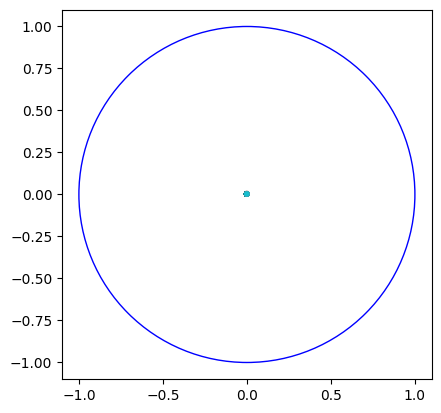

In [8]:
# Create a rendering of the embedding and save it to a file
if not os.path.exists("results"):
    os.mkdir("results")
fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.savefig(f"results/{dataset.name}.png")

In [9]:
# This renders a GIF animation of the embedding process. If FFMPEG is installed, the command also supports .mp4 as file ending 
animate(logging_dict, dataLabels, f"results/{dataset.name}_ani.gif", fast=True, plot_ee=True)

Animation being saved to: results/C_ELEGANS_ani.gif


Animating:   0%|                                                                                                                                                   | 0/80 [00:00<?, ?it/s]/home/yk/Coding/research_project/hyperbolic-tsne/hyperbolicTSNE/visualization.py:322: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=80.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
Animating: : 83it [00:14,  5.59it/s]                                                                                                                                                      
